In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
# ¿eager execution o graph execution?
disable_eager_execution()

In [4]:
iv3 = InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.


2022-03-17 19:46:55.163117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-17 19:46:55.163167: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-17 19:46:55.163202: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-luisxxx0-2dcosillas-2dia-2d5kwftoqx): /proc/driver/nvidia/version does not exist
2022-03-17 19:47:02.688126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print(iv3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [6]:
from keras.preprocessing import image

x = image.img_to_array(image.load_img("Cerveza.jpg", target_size=(299,299)))

# cambio de rango : 0-255 -> -1-1
x /= 255 # se divide entre el maximo rango
x -= 0.5
x *= 2 # distancia entre -1 y 1

x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]]) # el modelo necesita de un tensor de 4 dimensiones
                                            # la primera es el tamaño del lote, es decir, la cantidad de imagenes a procesar
y = iv3.predict(x)

/srv/conda/envs/notebook/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [7]:
decode_predictions(y)

[[('n02823750', 'beer_glass', 0.97993326),
  ('n02823428', 'beer_bottle', 0.0027135082),
  ('n07584110', 'consomme', 0.001833578),
  ('n03950228', 'pitcher', 0.001137751),
  ('n03026506', 'Christmas_stocking', 0.0006267249)]]

## Ataques adversarios

In [8]:
# -¿Por alguna razón no sirve?
capa_ent = iv3.layers[0].input
capa_sal = iv3.layers[-1].output

clase_obj = 951 # Identificador clase limón

perdida = capa_sal[0, clase_obj]
# with tf.GradientTape() as cinta:
   # perdida = capa_sal[0, clase_obj]
    
grad = K.gradients(perdida, capa_ent)[0]
# grad = cinta.gradient(perdida, iv3.layers[0].trainable_variables)[0]

grad_mejor = K.function([capa_ent, K.learning_phase()], [grad, perdida])

adv = np.copy(x)

pert = 0.01

max_pert = x + 0.01
min_pert = x - 0.01

coste = 0.0

while coste < 0.95:
  gr, coste = grad_mejor([adv, 0]) # se pasa 0 porque se va a probar el modelo
  adv += gr
  adv = np.clip(adv, min_pert, max_pert) # se recorta en los limites establecidos en la perturbación de la imagen
  adv = np.clip(adv, -1, 1) # rango aceptado por el modelo
  print("Probabilidad del limon:", coste)

pirat = np.copy(adv)

Probabilidad del limon: 0.00013334895
Probabilidad del limon: 0.00013531801
Probabilidad del limon: 0.0001373418
Probabilidad del limon: 0.00013939409
Probabilidad del limon: 0.00014149596
Probabilidad del limon: 0.0001436363
Probabilidad del limon: 0.0001458191
Probabilidad del limon: 0.00014804988
Probabilidad del limon: 0.00015035647
Probabilidad del limon: 0.00015274137
Probabilidad del limon: 0.00015518884
Probabilidad del limon: 0.0001576776
Probabilidad del limon: 0.00016021014
Probabilidad del limon: 0.0001627868
Probabilidad del limon: 0.0001653853
Probabilidad del limon: 0.00016801606
Probabilidad del limon: 0.00017071539
Probabilidad del limon: 0.00017350858
Probabilidad del limon: 0.00017636121
Probabilidad del limon: 0.00017928178
Probabilidad del limon: 0.00018229651
Probabilidad del limon: 0.00018541749
Probabilidad del limon: 0.00018864695
Probabilidad del limon: 0.00019197096
Probabilidad del limon: 0.00019539073
Probabilidad del limon: 0.00019890352
Probabilidad del l

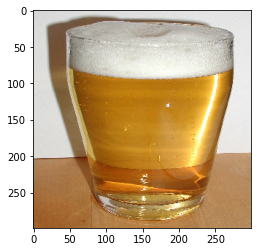

In [9]:
# se reformatea de -1-1 -> 0-255
adv /= 2
adv += 0.5
adv *= 255

plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [12]:
from PIL import Image

im = Image.fromarray(adv[0].astype(np.uint8))
im.save("./pirateada.png")